In [29]:
close all;
clear all;
%Folder = '/home/aos/MyProjects/MegaLab/Data/MGMSU/Patient_3_14_10_2018/EachFinger/';
Folder = 'MGMSU/141018/fingers/';
Folder_2 = 'MGMSU/151018/fingers/';
%Folder = 'Polenova/fingers/';
[files] = dir(Folder);
Files = files(3:end);
%Files.name

In [30]:
%Files([2,4:7,8:11,1]).name
%Files([2:5,6:10,1]).name
%Files([3:11,1]).name

In [31]:
Files = Files([2:4,6:11,1]);
Files.name


ans =

    '1_left_little_60s_10-14_13-47-28.mat'


ans =

    '2_left_ring_60s_10-14_13-48-55.mat'


ans =

    '3_left_middle_60s_10-14_13-50-13.mat'


ans =

    '4_left_index_60s_10-14_13-52-40.mat'


ans =

    '5_left_thumb_60s_10-14_13-54-03.mat'


ans =

    '6_right_thumb_60s_10-14_14-00-22.mat'


ans =

    '7_right_index_60s_10-14_13-59-10.mat'


ans =

    '8_right_middle_60s_10-14_13-57-57.mat'


ans =

    '9_right_ring_60s_10-14_13-56-41.mat'


ans =

    '10_right_little_60s_10-14_13-55-21.mat'



In [32]:
[files_2] = dir(Folder_2);
Files_2 = files_2(3:end);
Files_2 = Files_2([2:5,6:10,1]);
Files_2.name


ans =

    '1_left_little_60s_10-15_13-54-00.mat'


ans =

    '2_left_ring_60s_10-15_13-55-14.mat'


ans =

    '3_left_middle_60s_10-15_13-56-29.mat'


ans =

    '4_left_index_60s_10-15_13-57-45.mat'


ans =

    '5_left_thumb_60s_10-15_13-59-04.mat'


ans =

    '6_right_thumb_60s_10-15_14-05-24.mat'


ans =

    '7_right_index_60s_10-15_14-04-02.mat'


ans =

    '8_right_middle_60s_10-15_14-02-49.mat'


ans =

    '9_right_ring_60s_10-15_14-01-36.mat'


ans =

    '10_right_little_60s_10-15_14-00-22.mat'



In [33]:
numch = 64

Fs = 2048;
Fclow = 5;
% list bad channels
[becog,aecog] = butter(4,Fclow/(Fs/2),'high' );
[b_bs,a_bs] = butter(4,[48 52]/(Fs/2),'stop' );

%create a battery of filters
[b_bp_05_4,a_bp_05_4] = butter(3,[0.5 4]/(Fs/2) );
[b_lp_05,a_lp_05] = butter(4,[0.5/(Fs/2)],'low');
[b_lp_2,a_lp_2] = butter(3,[2/(Fs/2)],'low');
[b_lp_1,a_lp_1] = butter(3,[1/(Fs/2)],'low');
[b_hp_05,a_hp_05] = butter(3,[0.5/(Fs/2)],'high');
[blp1,alp1] = butter(3,[7.5/1000],'low');

%extract movement intensity parameter
     
%extract features using wvt transform
% compute scales serving 50-300 Hz range for 
%[scales,F] = frq2scale(10,90,50,'cmor1-1.5',2.5/Fs);
%F = scal2frq(scales,'cmor1-1.5',2.5/Fs); 
Ts = 1;


f0  = 5:5:150;
clear b a
for fi = 1:length(f0)
    [b{fi},a{fi}] = fir1(256,[0.9*f0(fi), 1.1*f0(fi)]/(Fs/2));
end;



numch =

    64



In [34]:
Qall = zeros([numch, length(Files)]);

Qpos = zeros(numch, length(Files));
Qneg = zeros(numch, length(Files));

Qvelpos = zeros(numch, length(Files));
Qvelneg = zeros(numch, length(Files));

Qnn = zeros([numch, length(Files)]);
Qnp = zeros([numch, length(Files)]);
Qpp = zeros([numch, length(Files)]);
Qpn = zeros([numch, length(Files)]);

In [35]:
testfirst = 0


testfirst =

     0



In [36]:
for fn = 1:length(Files)

        disp(Files(fn).name);
        disp(Files_2(fn).name);
        
        f1 = load([Folder Files(fn).name]);
        f2 = load([Folder_2 Files_2(fn).name]);
        
        Ntr = size(f1.ECOG,1);
        disp(Ntr);
        
        Myo = [f1.ECOG(:,1:numch); f2.ECOG(:,1:numch)];
        Myo = filtfilt(becog,aecog,Myo);
        Myo = filtfilt(b_bs,a_bs,Myo);
        MyoNg = Myo';
        
        PN = [f1.PN; f2.PN];
        PNf = filtfilt(b_lp_2, a_lp_2,PN)';
        PNf = filtfilt(b_hp_05, a_lp_05, PN)';
        PNfVar = std(PNf,[],2);
        [val, pnmax ] = max(PNfVar);
        
        disp(pnmax);

        parfor ch = 1:numch %size(MyoNg,1)
        
        
                c0 = zeros(length(f0),size(MyoNg,2))
                for fi = 1:length(f0)
                    c0(fi,:) = filtfilt(b{fi},a{fi},MyoNg(ch,:));
                end
              
                c1 = abs(c0);
                c1 = diag((1./sum(c1,2)))*c1;
                
                
                
                %Ntr = fix(size(c1,2)/2);
               
                %for pn =  1:size(PNf,1)
                    mv = PNf(pnmax,:);
                    vel = [0 diff(mv)];
                    
                    
                    todec = vel
                    
                    
                    Qall(ch,fn) = wienertraintest(todec,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                    

                    mv_sel = todec.*(mv > 0);
                    Qpos(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                                        
                    mv_sel = todec.*(mv < 0);
                    Qneg(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                    
                    
                    mv_sel = todec.*(vel > 0);
                    Qvelpos(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                    
                    mv_sel = todec.*(vel < 0);
                    Qvelneg(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                    

                    % --
                    ifsel = and(mv < 0, vel < 0);
                    mv_sel =  todec.*ifsel;
                    Qnn(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                    
                    % -+
                    ifsel = and(mv < 0, vel > 0);
                    mv_sel =  todec.*ifsel;
                    Qnp(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                    
                    % ++
                    ifsel = and(mv > 0, vel > 0);
                    mv_sel =  todec.*ifsel;
                    Qpp(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                    
                    % +-
                    ifsel = and(mv > 0, vel < 0);
                    mv_sel =  todec.*ifsel;
                    Qpn(ch,fn) = wienertraintest(mv_sel,c1,Ntr,a_lp_2,b_lp_2,testfirst);
                   
                    
               % end

        end

end

1_left_little_60s_10-14_13-47-28.mat
1_left_little_60s_10-15_13-54-00.mat
      122880

    10

2_left_ring_60s_10-14_13-48-55.mat
2_left_ring_60s_10-15_13-55-14.mat
      122880

     9

3_left_middle_60s_10-14_13-50-13.mat
3_left_middle_60s_10-15_13-56-29.mat
      122912

     8

4_left_index_60s_10-14_13-52-40.mat
4_left_index_60s_10-15_13-57-45.mat
      122976

     7

5_left_thumb_60s_10-14_13-54-03.mat
5_left_thumb_60s_10-15_13-59-04.mat
      122944

     9

6_right_thumb_60s_10-14_14-00-22.mat
6_right_thumb_60s_10-15_14-05-24.mat
      123168

     1

7_right_index_60s_10-14_13-59-10.mat
7_right_index_60s_10-15_14-04-02.mat
      122912

     2

8_right_middle_60s_10-14_13-57-57.mat
8_right_middle_60s_10-15_14-02-49.mat
      122976

     3

9_right_ring_60s_10-14_13-56-41.mat
9_right_ring_60s_10-15_14-01-36.mat
      122912

     4

10_right_little_60s_10-14_13-55-21.mat
10_right_little_60s_10-15_14-00-22.mat
      123168

     5



In [37]:
%nametosave = 'polenova_161018_'
if(testfirst)
    %nametosave = 'VEL_mgmsu_151018_test_first_'
    nametosave = 'new_VEL_mgmsu_crossdays_test_first_'
else
    %nametosave = 'VEL_mgmsu_151018_test_last_'
    nametosave = 'new_VEL_mgmsu_crossdays_test_last_'
end


nametosave =

    'new_VEL_mgmsu_crossdays_test_last_'



In [38]:
xlabels = {'Little (L)','Ring (L)','Middle (L)','Index (L)','Thumb (L)','Thumb (R)','Index (R)','Middle (R)','Ring (R)','Little (R)'};


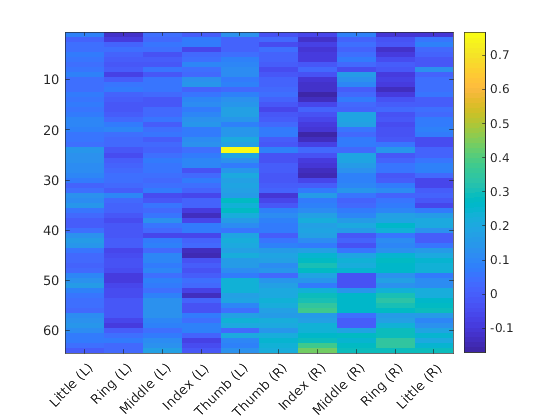

In [24]:
close all
figure;
%subplot(1,2,1)
imagesc(Qall)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'all.png']);

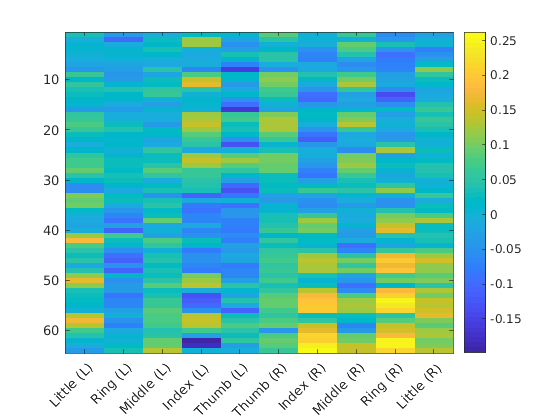

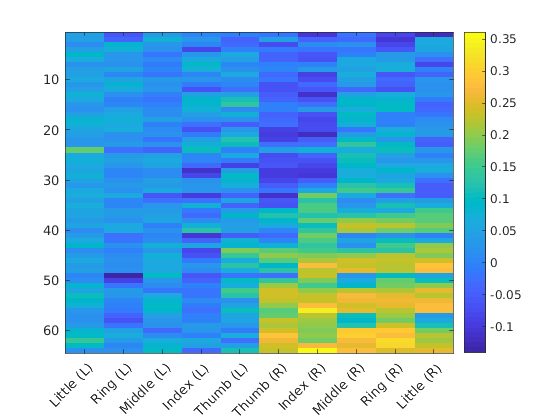

In [12]:
close all
figure;
%subplot(1,2,1)
imagesc(Qpos)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'pos.png']);

figure;
%subplot(1,2,1)
imagesc(Qneg)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'neg.png']);

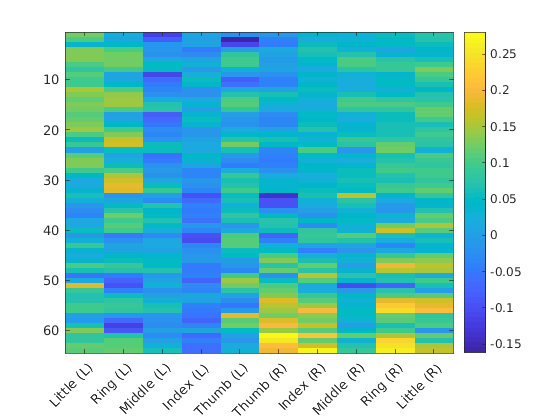

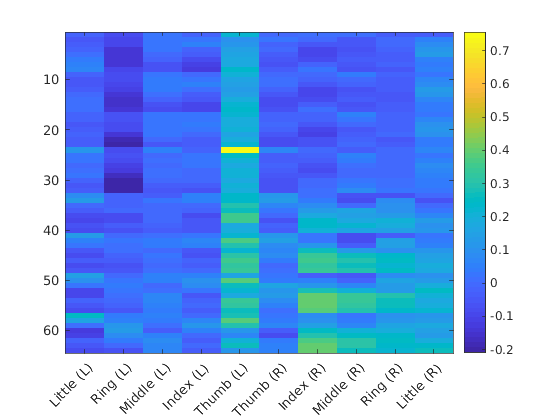

In [14]:
close all
figure;
%subplot(1,2,1)
imagesc(Qvelpos)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'velpos.png']);

figure;
%subplot(1,2,1)
imagesc(Qvelneg)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'velneg.png']);

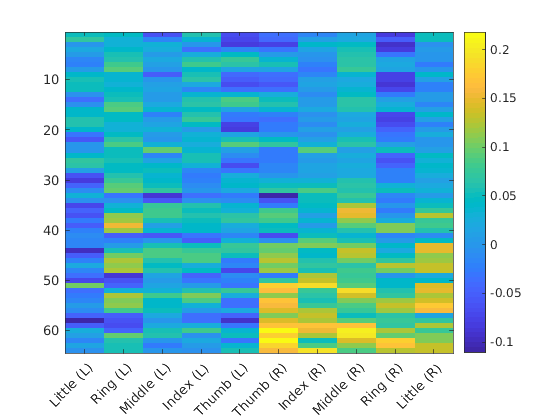

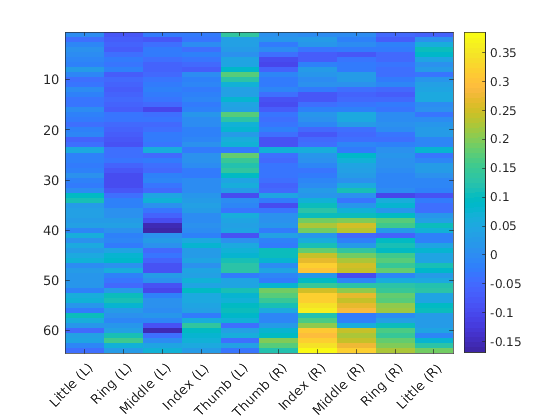

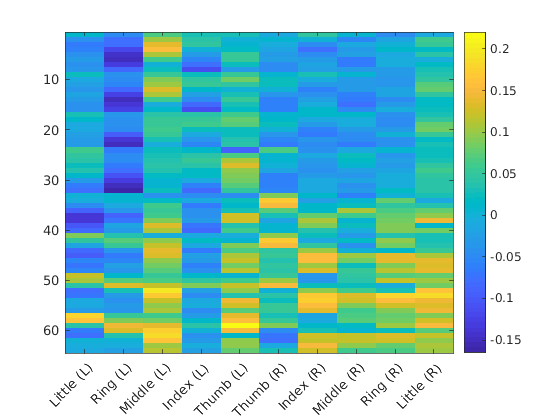

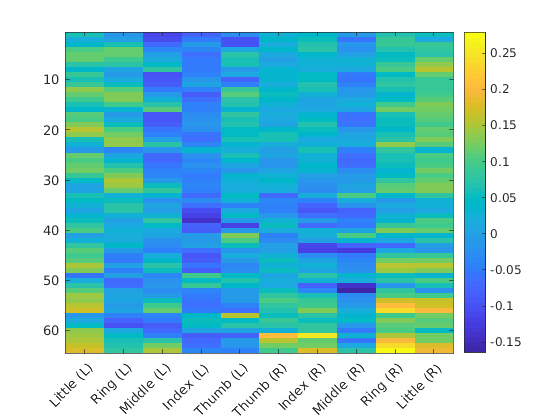

In [15]:
figure;%subplot(2,2,1)
imagesc(Qnn)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'nn.png']);

figure;%subplot(2,2,2)
imagesc(Qnp)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'np.png']);

figure;%subplot(2,2,3)
imagesc(Qpp)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'pp.png']);

figure;%subplot(2,2,4)
imagesc(Qpn)
set(gca, 'XTick', 1:10, 'XTickLabel', xlabels);
xtickangle(45);
colorbar
saveas(gcf,[nametosave,'pn.png']);

In [16]:
fingers_8_by_8_all = reshape(Qall(:,6:end)',[5,8,8]);
fingers_8_by_8_pos = reshape(Qpos(:,6:end)',[5,8,8]);
fingers_8_by_8_neg = reshape(Qneg(:,6:end)',[5,8,8]);
fingers_8_by_8_velpos = reshape(Qvelpos(:,6:end)',[5,8,8]);
fingers_8_by_8_velneg = reshape(Qvelneg(:,6:end)',[5,8,8]);

fingers_8_by_8_nn = reshape(Qnn(:,6:end)',[5,8,8]);
fingers_8_by_8_np = reshape(Qnp(:,6:end)',[5,8,8]);
fingers_8_by_8_pp = reshape(Qpp(:,6:end)',[5,8,8]);
fingers_8_by_8_pn = reshape(Qpn(:,6:end)',[5,8,8]);

save('VEL_cross_test_first_fingers_8_by_8.mat', 'fingers_8_by_8_all', ...
                                    'fingers_8_by_8_pos', ...
                                    'fingers_8_by_8_neg', ...                                    
                                    'fingers_8_by_8_velpos', ...       
                                    'fingers_8_by_8_velneg', ...
                                    'fingers_8_by_8_nn', ...
                                    'fingers_8_by_8_np', ...
                                    'fingers_8_by_8_pp', ...
                                    'fingers_8_by_8_pn')

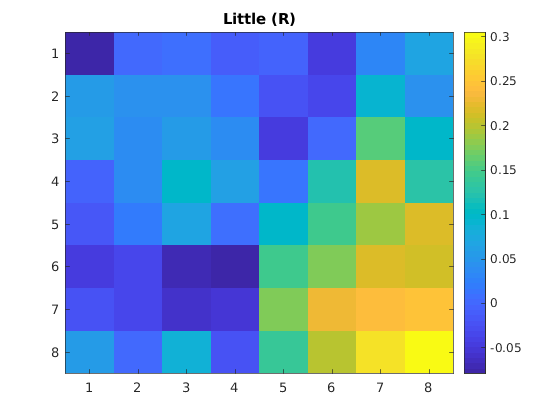

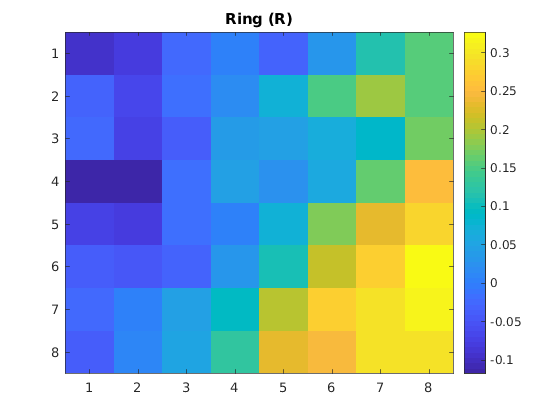

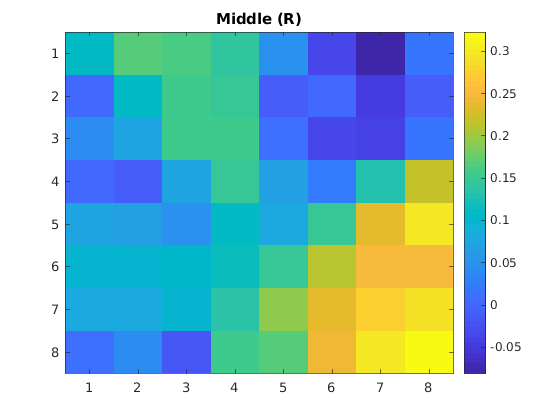

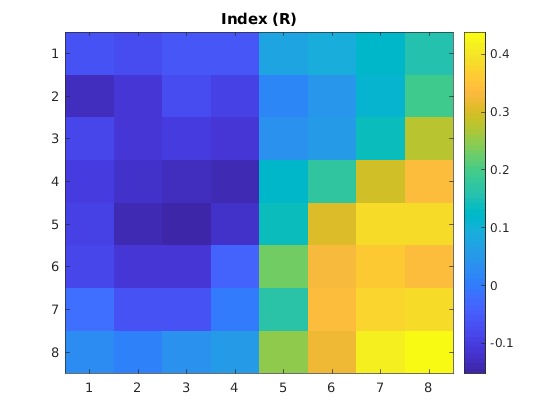

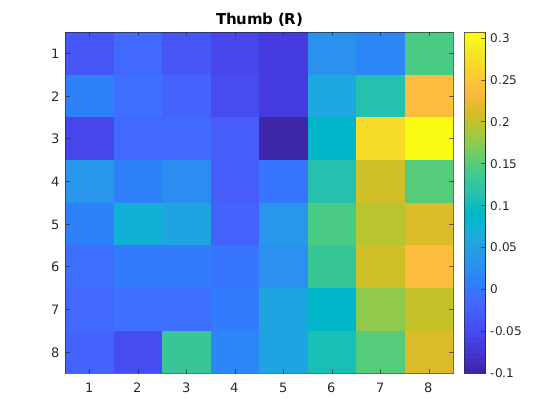

In [17]:
for i = 1:5
    figure;
    imagesc(squeeze(fingers_8_by_8_all(i,:,:)))
    colorbar
    title(xlabels(i+5))
    colorbar
end

In [39]:
fn = 5;

disp(Files(fn).name);
disp(Files_2(fn).name);

f1 = load([Folder Files(fn).name]);
f2 = load([Folder_2 Files_2(fn).name]);

Ntr = size(f1.ECOG,1);
disp(Ntr);

Myo = [f1.ECOG(:,1:numch); f2.ECOG(:,1:numch)];
Myo = filtfilt(becog,aecog,Myo);
Myo = filtfilt(b_bs,a_bs,Myo);
MyoNg = Myo';

PN = [f1.PN; f2.PN];
PNf = filtfilt(b_lp_2, a_lp_2,PN)';
PNf = filtfilt(b_hp_05, a_lp_05, PN)';
PNfVar = std(PNf,[],2);
[val, pnmax ] = max(PNfVar);

disp(pnmax);

ch = 24 %size(MyoNg,1)

c0 = zeros(length(f0),size(MyoNg,2));
for fi = 1:length(f0)
c0(fi,:) = filtfilt(b{fi},a{fi},MyoNg(ch,:));
end

c1 = abs(c0);
c1 = diag((1./sum(c1,2)))*c1;



%Ntr = fix(size(c1,2)/2);

%for pn =  1:size(PNf,1)
mv = PNf(pnmax,:);
vel = [0 diff(mv)];


todec = vel;


Qall(ch,fn) = wienertraintest(todec,c1,Ntr,a_lp_2,b_lp_2,testfirst);


5_left_thumb_60s_10-14_13-54-03.mat
5_left_thumb_60s_10-15_13-59-04.mat
      122944

     9


ch =

    24



In [41]:
mv_ts = todec;
feat_ts = c1;
N_del = Ntr;

if(testfirst)
    W = (mv_ts(N_del+1:end)*feat_ts(:,N_del+1:end)')*pinv(feat_ts(:,N_del+1:end)*feat_ts(:,N_del+1:end)',0.000);
else
    W = (mv_ts(1:N_del)*feat_ts(:,1:N_del)')*pinv(feat_ts(:,1:N_del)*feat_ts(:,1:N_del)',0.000);
end


z0 = W*feat_ts;
z = filtfilt(b_lp_2,a_lp_2,z0);

if(testfirst)
    qq = corrcoef(z(1:N_del),mv_ts(1:N_del));
else
    qq = corrcoef(z(N_del+1:end),mv_ts(N_del+1:end));        
end

qq(1,2)


ans =

    0.7679



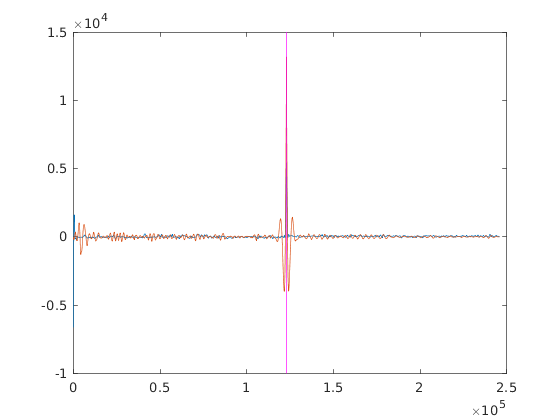

In [74]:
figure;
plot(z);%(end-Fs*80:end-Fs*30));
hold on;
plot(mv_ts);%(end-Fs*80:end-Fs*30));
idx_x = 1:size(mv_ts,1);

plot([Ntr,Ntr],[-10000,15000],'m')
%ylim([-0.5*1000,0.5*1000])

In [62]:
corrcoef(z(end-Fs*50:end-Fs*10),mv_ts(end-Fs*50:end-Fs*10))


ans =

    1.0000   -0.0794
   -0.0794    1.0000



In [77]:
load([Folder Files(fn).name]);
Myo = ECOG(:,1:numch);
Myo = filtfilt(becog,aecog,Myo);
Myo = filtfilt(b_bs,a_bs,Myo);
MyoNg = Myo';

PNf = filtfilt(b_lp_2, a_lp_2,PN)';
PNf = filtfilt(b_hp_05, a_lp_05, PN)';
PNfVar =std(PNf,[],2);
[val, pnmax ] = max(PNfVar);

In [78]:
ch = 50

c0 = zeros(length(f0),size(MyoNg,2));
for fi = 1:length(f0)
    c0(fi,:) = filtfilt(b{fi},a{fi},MyoNg(ch,:));
end

c1 = abs(c0);
c1 = diag((1./sum(c1,2)))*c1;

Ntr = fix(size(c1,2)/2);


ch =

    50



In [79]:
mv = PNf(pnmax,:);
mvpos =  mv;%.*(mv>0);
W = (mvpos(Ntr+1:end)*c1(:,Ntr+1:end)')*pinv(c1(:,Ntr+1:end)*c1(:,Ntr+1:end)',0.000);

z0 = W*c1;
z = filtfilt(b_lp_2,a_lp_2,z0);
qq = corrcoef(z(1:Ntr),mvpos(1:Ntr));
disp(qq(1,2))

    0.5067



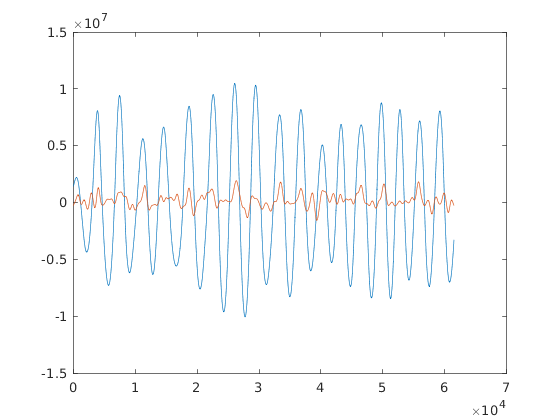

In [44]:
plot(mvpos(1:Ntr));
hold on;
plot(z(1:Ntr));
saveas(gcf,[nametosave,'ch50_f10_test.png']);

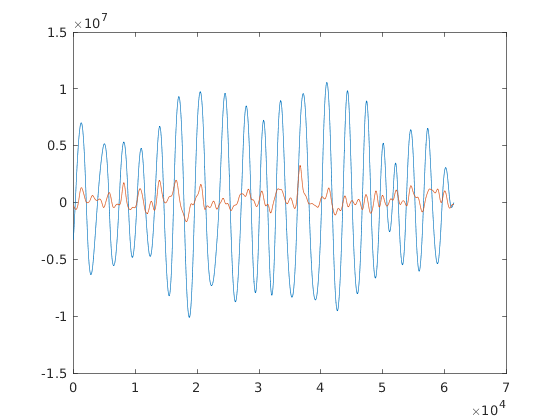

In [45]:
plot(mvpos(Ntr+1:end));
hold on;
plot(z(Ntr+1:end));
saveas(gcf,[nametosave,'ch50_f10_train.png']);

In [70]:
mv = PNf(pnmax,:);
mvpos =  mv.*(mv>0);
W = (mvpos(Ntr+1:end)*c1(:,Ntr+1:end)')*pinv(c1(:,Ntr+1:end)*c1(:,Ntr+1:end)',0.000);

z0 = W*c1;
z = filtfilt(b_lp_2,a_lp_2,z0);
qq = corrcoef(z(1:Ntr),mvpos(1:Ntr));
disp(qq(1,2))

    0.5926



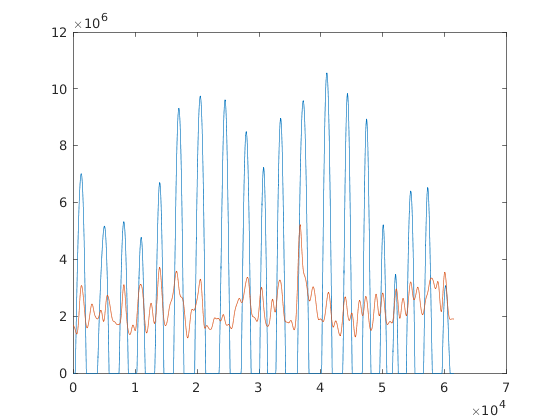

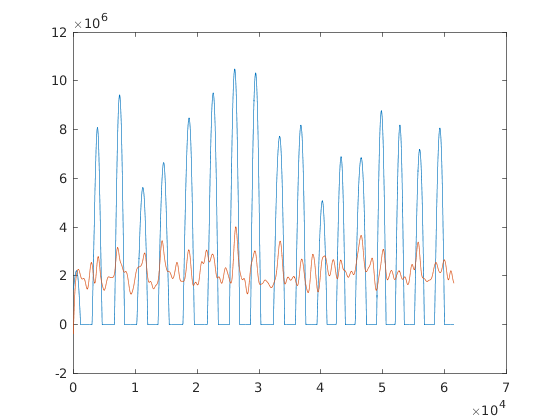

In [72]:
figure;
plot(mvpos(1:Ntr));
hold on;
plot(z(1:Ntr));
saveas(gcf,[nametosave,'ch50_f10_pos_test.png']);

figure;
plot(mvpos(Ntr+1:end));
hold on;
plot(z(Ntr+1:end));
saveas(gcf,[nametosave,'ch50_f10_pos_train.png']);

Invalid backend, should be one of ['inline', 'native']


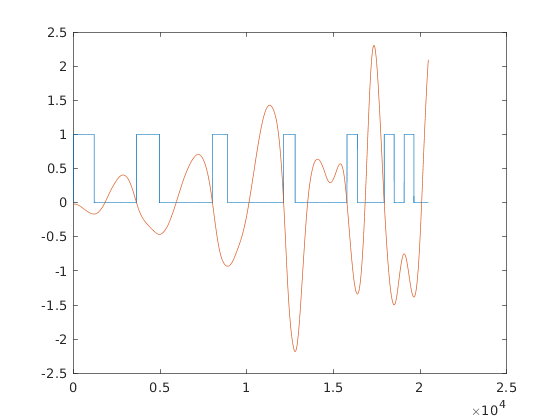

In [31]:
%plot(mv(1:Fs*10) > 0)
plot(and(acc(1:Fs*10) < 0,mv(1:Fs*10) < 0))
%plot(~xor(acc(1:Fs*10) > 0,mv(1:Fs*10) > 0))
hold on
%plot(mv(1:Fs*10) < 0)
%plot(acc(1:Fs*10) < 0)

plot(mv(1:Fs*10)/100000)
